In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_fix import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle
from torch import autograd
torch.manual_seed(2)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

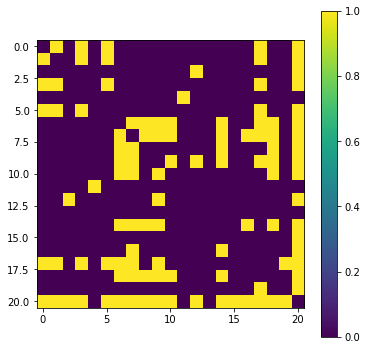

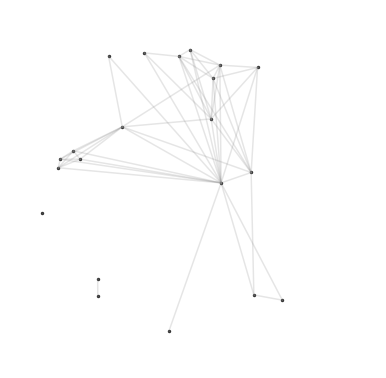

In [5]:
N = 21
R = torch.tensor([5.0]).double()
alpha = .7
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [6]:
r_init = noise_r(r, R, rel_var=0.05)
phi_init = noise_phi(theta, 0.05)

r_loc_init = logit(r_init/R)*R/5
r_scale_init = torch.ones([N]).double().log()
phi_loc_init = polar2cart(1, phi_init)
phi_scale_init = (torch.ones([N]).double()*10).log()

In [7]:
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()

In [8]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_HRG(N,10, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':phi_scale_init, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init},
           fixed={'R':R, 'T':T, 'alpha':alpha})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())
#vi.optimizer.lr

In [20]:
with autograd.detect_anomaly():
    #vi.train(dataloader, lrs=0.1, debug=False, epochs=50)
    vi.train(dataloader, lrs=0.01, debug=False, epochs=50)

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.01 | Total loss: 496.65 | Epoch time 2.52
Epoch 2 | LR: 0.01 | Total loss: 475.75 | Epoch time 2.20
Epoch 3 | LR: 0.01 | Total loss: 475.00 | Epoch time 5.28
Epoch 4 | LR: 0.01 | Total loss: 473.50 | Epoch time 3.00
Epoch 5 | LR: 0.01 | Total loss: 472.43 | Epoch time 3.17
Epoch 6 | LR: 0.01 | Total loss: 472.94 | Epoch time 2.46
Epoch 7 | LR: 0.01 | Total loss: 470.82 | Epoch time 2.52
Epoch 8 | LR: 0.01 | Total loss: 471.45 | Epoch time 2.38
Epoch 9 | LR: 0.01 | Total loss: 472.69 | Epoch time 2.34
Epoch 10 | LR: 0.01 | Total loss: 471.65 | Epoch time 2.59
Epoch 11 | LR: 0.01 | Total loss: 472.08 | Epoch time 2.31
Epoch 12 | LR: 0.01 | Total loss: 469.75 | Epoch time 2.25
Epoch 13 | LR: 0.01 | Total loss: 469.89 | Epoch time 3.23
Epoch 14 | LR: 0.01 | Total loss: 469.63 | Epoch time 2.34
Epoch 15 | LR: 0.01 | Total loss: 471.23 | Epoch time 2.94
Epoch 16 | LR: 0.01 | Total loss: 469.96 | Epoch time 3.18
Epoch 17 | LR: 0.01 | Total loss: 

In [21]:
rs_, phis_, R_, T_, alpha_ = vi.qmean()
print(R_, T_, alpha_)

tensor([5.], dtype=torch.float64) tensor(0.1000, dtype=torch.float64) tensor(0.7000, dtype=torch.float64)


### Original

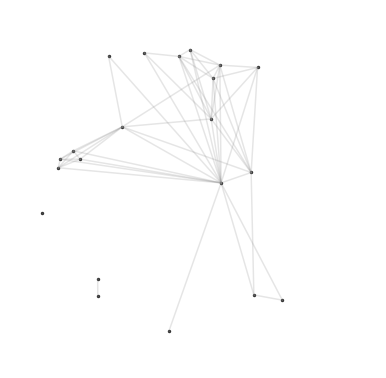

In [22]:
G.plot()

### Initialized (with noise)

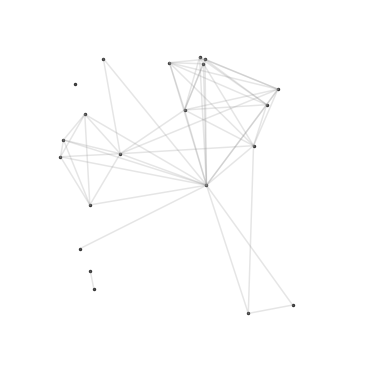

In [23]:
G_init = HRG(R=R, alpha=alpha, T=T)
G_init.r, G_init.theta, G_init.A = r_init, phi_init, A
G_init.plot()

### Estimated

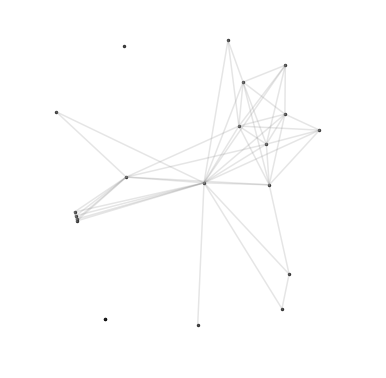

In [24]:
G_post = HRG(R=R_, alpha=alpha_, T=T_)
G_post.r, G_post.theta, G_post.A = rs_, c2d(phis_), A
G_post.plot()

In [25]:
nodes = vi.posterior_samples(100)

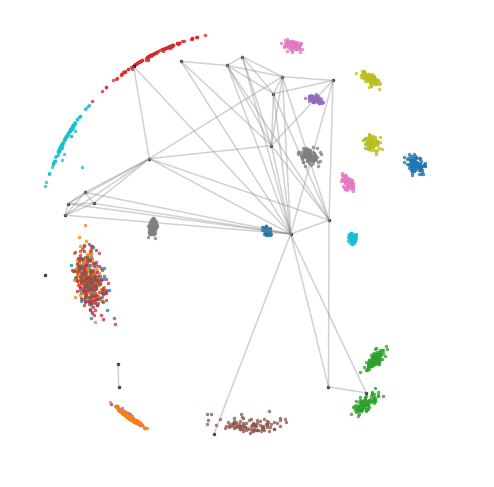

In [26]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
for link in A.nonzero():
    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show() 

In [16]:
r_x_loc, r_x_scale, phi_x_loc, phi_x_scale, R_x_conc, R_x_scale, T_x, \
            alpha_x_conc, alpha_x_scale = vi.constrained_params()

In [17]:
phi_x_scale

tensor([107.5068, 104.4273, 124.3168, 106.1133, 100.5668,  96.3466, 189.0461,
        195.1718, 135.7162, 226.1097, 180.7206, 103.3811, 156.8566,  25.9940,
        275.3276,  18.0899, 230.4938, 175.7861, 251.4075,  51.5049,  44.2401],
       dtype=torch.float64, grad_fn=<ExpBackward>)

In [18]:
torch.exp(torch.tensor(0.)).expand(10)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
theta

tensor([2.9282, 2.8926, 5.3700, 2.8429, 3.9688, 2.9908, 1.3825, 1.3610, 1.6153,
        0.2878, 1.1028, 3.8810, 5.2092, 3.2964, 1.7015, 4.5223, 1.9356, 2.4457,
        1.4193, 2.1551, 0.2306], dtype=torch.float64)